In [5]:
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
import pandas as pd

## 1. Load the Best Probe Weights

In [13]:
# Path to your results
# MODEL_NAME = "Qwen/Qwen2.5-Math-7B-Instruct"
# MODEL_NAME = "Qwen/Qwen3-4B-Instruct-2507"
MODEL_NAME = "Qwen/Qwen2.5-Math-1.5B-Instruct"
# MODEL_NAME = "Qwen/Qwen2.5-Math-1.5B"
MODEL_ALIAS = "-".join(MODEL_NAME.split("/"))
RESULTS_DIR = f"../probe_results/DATA/SR_DATA/MATH/{MODEL_ALIAS}_maxlen_3000_k_50_temp_1.0"

# Load best probe data
with open(f"{RESULTS_DIR}/best_probe_predictions.json", 'r') as f:
    best_probe = json.load(f)

probe_weights = np.array(best_probe['probe_weights'])  # [D] dimension vector
best_layer = best_probe['best_layer']
best_position = best_probe['best_position']
cv_score = best_probe['cv_score']
test_score = best_probe['test_score']

print(f"Best probe: Layer {best_layer}, Position {best_position}")
print(f"CV Score: {cv_score:.4f}, Test Score: {test_score:.4f}")
print(f"Probe weights shape: {probe_weights.shape}")

Best probe: Layer 18, Position -1
CV Score: 0.7774, Test Score: 0.7599
Probe weights shape: (1536,)


## 2. Load Model and Extract Embedding Matrix

In [14]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
vocab_size = len(tokenizer)
print(f"Vocabulary size: {vocab_size}")

# Load model to get embeddings
print("Loading model (this may take a moment)...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="cpu",  # Keep on CPU for analysis
)

# Get embedding matrix
embedding_matrix = model.get_input_embeddings().weight.data.cpu().float().numpy()  # [vocab_size, d_model]
print(f"Embedding matrix shape: {embedding_matrix.shape}")

Vocabulary size: 151665
Loading model (this may take a moment)...
Embedding matrix shape: (151936, 1536)


## 3. Compute Dot Products with All Tokens

In [15]:
# Compute dot product: embedding_matrix @ probe_weights
# This tells us how much each token "activates" the probe direction
dot_products = embedding_matrix @ probe_weights  # [vocab_size]

print(f"Dot products shape: {dot_products.shape}")
print(f"Min: {dot_products.min():.4f}, Max: {dot_products.max():.4f}, Mean: {dot_products.mean():.4f}")

Dot products shape: (151936,)
Min: -0.0052, Max: 0.0062, Mean: 0.0005


## 4. Find Top Tokens (Highest Activations)

In [16]:
# Get top K tokens with highest dot products
TOP_K = 50

top_indices = np.argsort(dot_products)[-TOP_K:][::-1]  # Descending order
top_scores = dot_products[top_indices]
top_tokens = [tokenizer.decode([idx]) for idx in top_indices]

# Create DataFrame
top_df = pd.DataFrame({
    'rank': range(1, TOP_K + 1),
    'token_id': top_indices,
    'token': top_tokens,
    'dot_product': top_scores,
})

print(f"\n{'='*60}")
print(f"TOP {TOP_K} TOKENS (Highest Activation)")
print(f"{'='*60}\n")
print(top_df.to_string(index=False))


TOP 50 TOKENS (Highest Activation)

 rank  token_id         token  dot_product
    1     15442      evaluate     0.006188
    2     29033         stick     0.005812
    3     82345      Evaluate     0.005599
    4     48924    successive     0.005373
    5     19642       valuate     0.005186
    6     37563    evaluating     0.005141
    7    106325           所以在     0.005013
    8    118338            相符     0.004962
    9     54115      Evaluate     0.004864
   10     98949    chocolates     0.004785
   11     95362          thag     0.004730
   12      5553          ados     0.004718
   13     36693  translations     0.004691
   14     29208         -step     0.004625
   15     57817       theorem     0.004601
   16     10709     lications     0.004597
   17     91956            、“     0.004582
   18     45441      alculate     0.004578
   19     85657   arbitrarily     0.004527
   20     12446        verify     0.004524
   21    102086            评估     0.004507
   22     10146  

## 5. Find Bottom Tokens (Lowest Activations)

In [17]:
# Get bottom K tokens (most negative)
bottom_indices = np.argsort(dot_products)[:TOP_K]
bottom_scores = dot_products[bottom_indices]
bottom_tokens = [tokenizer.decode([idx]) for idx in bottom_indices]

bottom_df = pd.DataFrame({
    'rank': range(1, TOP_K + 1),
    'token_id': bottom_indices,
    'token': bottom_tokens,
    'dot_product': bottom_scores,
})

print(f"\n{'='*60}")
print(f"BOTTOM {TOP_K} TOKENS (Lowest Activation)")
print(f"{'='*60}\n")
print(bottom_df.to_string(index=False))


BOTTOM 50 TOKENS (Lowest Activation)

 rank  token_id        token  dot_product
    1       220                 -0.005164
    2      7886          sym    -0.005070
    3      2971    condition    -0.004434
    4     12128       closer    -0.004406
    5        83            t    -0.004164
    6     23802          sym    -0.004122
    7     76095           条件    -0.004042
    8     33798     readable    -0.004017
    9      5234          sem    -0.003959
   10    101147           方便    -0.003895
   11      2664       better    -0.003832
   12      8661       easier    -0.003789
   13     18267         semi    -0.003784
   14      1909          top    -0.003766
   15       709           ge    -0.003761
   16     96750           |^    -0.003752
   17     19703        roots    -0.003730
   18       256                 -0.003700
   19     12993        _root    -0.003685
   20     10277     properly    -0.003662
   21       262                 -0.003661
   22     99408            根    -0.00

## 6. Visualize Distribution

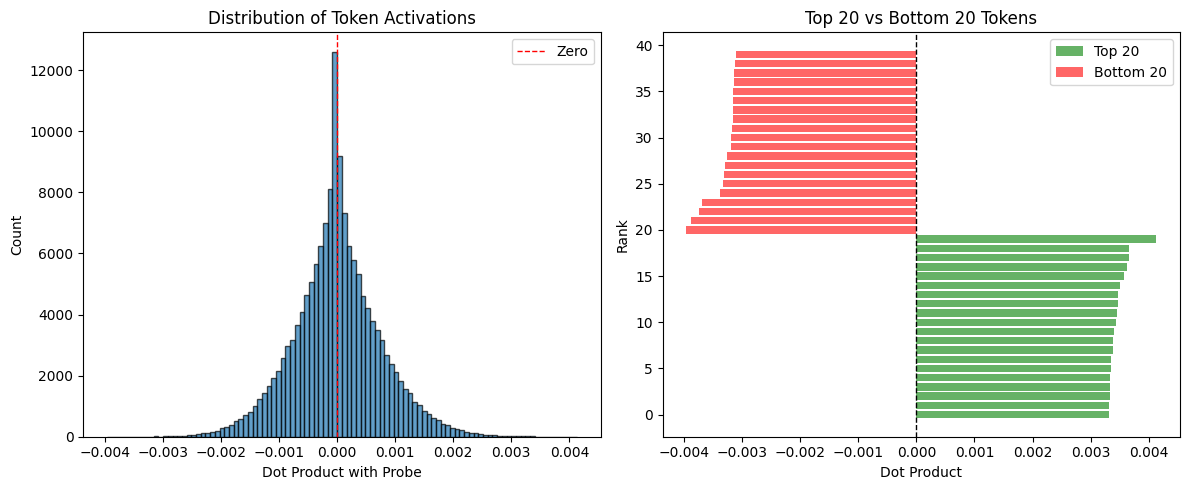

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(dot_products, bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('Dot Product with Probe')
plt.ylabel('Count')
plt.title('Distribution of Token Activations')
plt.axvline(0, color='red', linestyle='--', linewidth=1, label='Zero')
plt.legend()

# Top/Bottom bars
plt.subplot(1, 2, 2)
plt.barh(range(20), top_scores[:20][::-1], color='green', alpha=0.6, label='Top 20')
plt.barh(range(20, 40), bottom_scores[:20], color='red', alpha=0.6, label='Bottom 20')
plt.xlabel('Dot Product')
plt.ylabel('Rank')
plt.title('Top 20 vs Bottom 20 Tokens')
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.legend()

plt.tight_layout()
plt.show()

## 7. Save Results

In [10]:
# Save to CSV
top_df.to_csv(f"{RESULTS_DIR}/top_tokens.csv", index=False)
bottom_df.to_csv(f"{RESULTS_DIR}/bottom_tokens.csv", index=False)

print(f"\nResults saved to:")
print(f"  - {RESULTS_DIR}/top_tokens.csv")
print(f"  - {RESULTS_DIR}/bottom_tokens.csv")


Results saved to:
  - ../probe_results/DATA/SR_DATA/MATH/Qwen-Qwen2.5-Math-7B_maxlen_3000_k_50_temp_1.0/top_tokens.csv
  - ../probe_results/DATA/SR_DATA/MATH/Qwen-Qwen2.5-Math-7B_maxlen_3000_k_50_temp_1.0/bottom_tokens.csv


## 8. Interpretation

- **High dot product tokens**: These tokens, when they appear at the probe's position/layer, strongly activate in the direction the probe learned to associate with high success rate.
- **Low dot product tokens**: These tokens activate in the opposite direction

**Note**: This analysis uses the embedding matrix, so it shows tokens at the input level. The actual activations the probe sees are after being processed through layers of the transformer, so this is an approximation of what the probe detects.

## 9. Probe Performance Analysis

In [11]:
# Load predictions and ground truth
gts = best_probe["test_actual"]
preds = best_probe["test_predictions"]

# Ridge regression outputs are unbounded, clip to [0, 1] for success rate
preds_clipped = np.clip(preds, 0, 1)

print(f"Ground truth range: [{np.min(gts):.3f}, {np.max(gts):.3f}]")
print(f"Original predictions range: [{np.min(preds):.3f}, {np.max(preds):.3f}]")
print(f"Clipped predictions range: [{np.min(preds_clipped):.3f}, {np.max(preds_clipped):.3f}]")
print(f"\nDataset size: {len(gts)} problems")

Ground truth range: [0.000, 0.940]
Original predictions range: [-0.160, 0.981]
Clipped predictions range: [0.000, 0.981]

Dataset size: 5000 problems


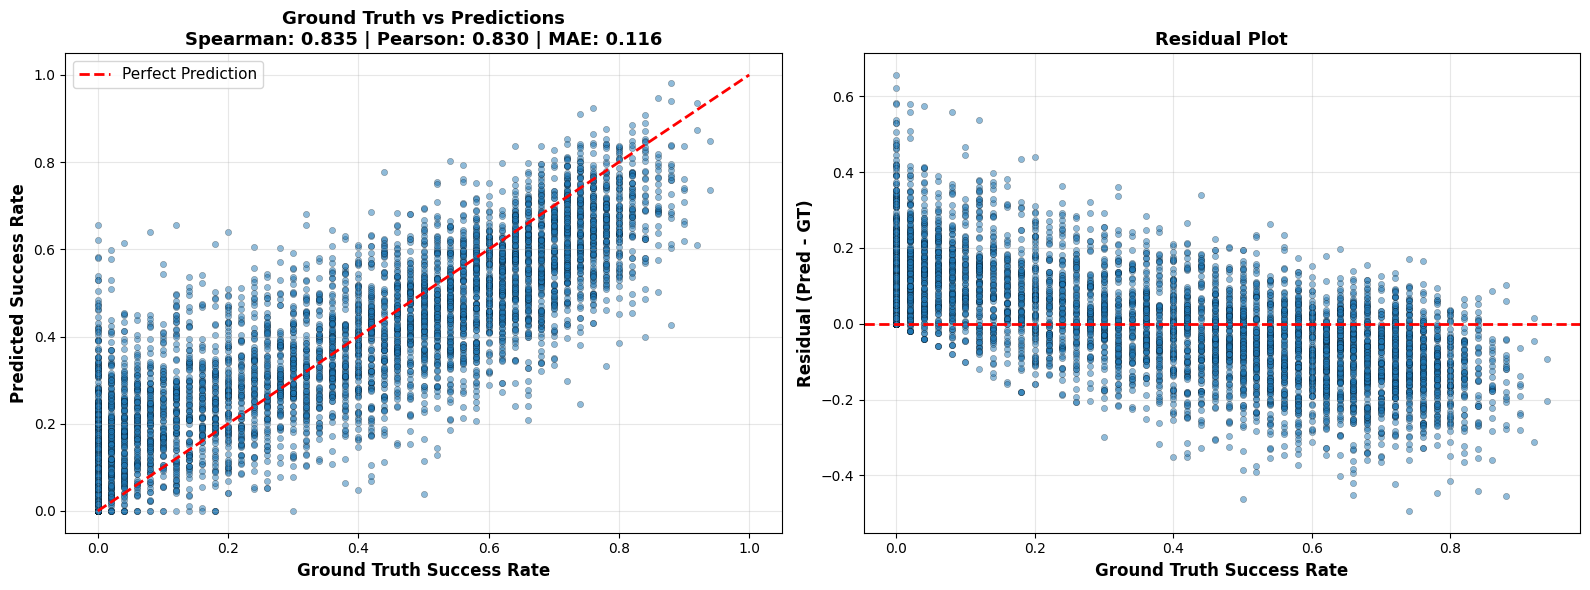


Metrics Summary:
  Spearman Correlation: 0.8351
  Pearson Correlation: 0.8301
  MAE: 0.1164
  RMSE: 0.1482


In [12]:
from scipy.stats import spearmanr, pearsonr

# Convert to numpy arrays
gts_arr = np.array(gts)
preds_arr = np.array(preds_clipped)

# Compute metrics
spearman_corr, _ = spearmanr(gts_arr, preds_arr)
pearson_corr, _ = pearsonr(gts_arr, preds_arr)
mae = np.mean(np.abs(gts_arr - preds_arr))
mse = np.mean((gts_arr - preds_arr)**2)
rmse = np.sqrt(mse)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Ground Truth vs Predictions scatter plot
axes[0].scatter(gts_arr, preds_arr, alpha=0.5, s=20, edgecolors='black', linewidth=0.3)
axes[0].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Ground Truth Success Rate', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted Success Rate', fontsize=12, fontweight='bold')
axes[0].set_title(f'Ground Truth vs Predictions\nSpearman: {spearman_corr:.3f} | Pearson: {pearson_corr:.3f} | MAE: {mae:.3f}', 
                  fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(-0.05, 1.05)
axes[0].set_ylim(-0.05, 1.05)

# Right: Residual plot
residuals = preds_arr - gts_arr
axes[1].scatter(gts_arr, residuals, alpha=0.5, s=20, edgecolors='black', linewidth=0.3)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Ground Truth Success Rate', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Residual (Pred - GT)', fontsize=12, fontweight='bold')
axes[1].set_title('Residual Plot', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nMetrics Summary:")
print(f"  Spearman Correlation: {spearman_corr:.4f}")
print(f"  Pearson Correlation: {pearson_corr:.4f}")
print(f"  MAE: {mae:.4f}")
print(f"  RMSE: {rmse:.4f}")

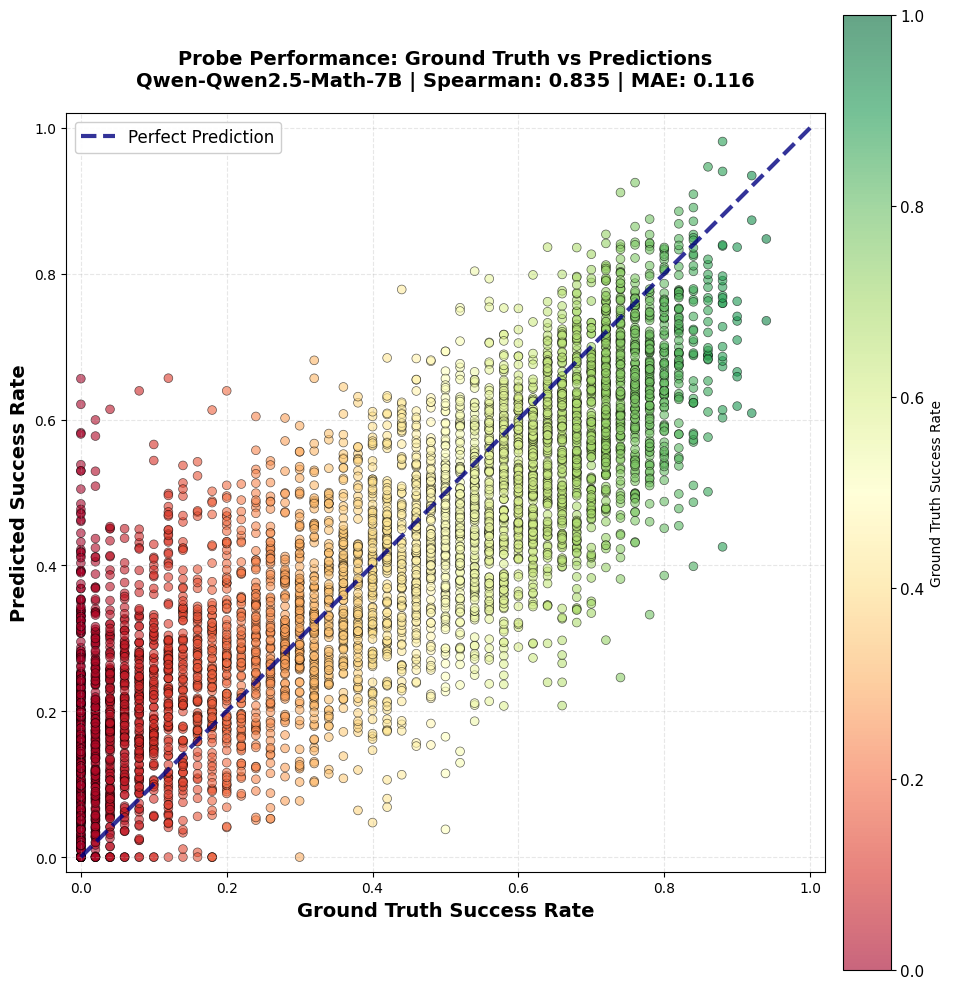


📊 Interpretation:
  • Points near the diagonal line indicate accurate predictions
  • Color shows ground truth: Green = high SR (easy), Red = low SR (hard)
  • Spearman 0.835 shows strong rank correlation
  • MAE 0.116 means average prediction error of ~11.6%


In [13]:
# Standalone: Ground Truth vs Predictions scatter plot
plt.figure(figsize=(10, 10))

# Create scatter plot with color-coded points
plt.scatter(gts_arr, preds_arr, alpha=0.6, s=40, c=gts_arr, cmap='RdYlGn', 
            edgecolors='black', linewidth=0.5, vmin=0, vmax=1)

# Add colorbar
cbar = plt.colorbar(label='Ground Truth Success Rate', pad=0.02)
cbar.ax.tick_params(labelsize=11)

# Perfect prediction line
plt.plot([0, 1], [0, 1], 'navy', linestyle='--', linewidth=3, 
         label='Perfect Prediction', alpha=0.8, zorder=5)

# Add grid
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)

# Labels and title
plt.xlabel('Ground Truth Success Rate', fontsize=14, fontweight='bold')
plt.ylabel('Predicted Success Rate', fontsize=14, fontweight='bold')
plt.title(f'Probe Performance: Ground Truth vs Predictions\n{MODEL_ALIAS} | Spearman: {spearman_corr:.3f} | MAE: {mae:.3f}', 
          fontsize=14, fontweight='bold', pad=20)

# Legend
plt.legend(fontsize=12, loc='upper left', framealpha=0.95)

# Set limits
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)

# Equal aspect ratio for square plot
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

print(f"\n📊 Interpretation:")
print(f"  • Points near the diagonal line indicate accurate predictions")
print(f"  • Color shows ground truth: Green = high SR (easy), Red = low SR (hard)")
print(f"  • Spearman {spearman_corr:.3f} shows strong rank correlation")
print(f"  • MAE {mae:.3f} means average prediction error of ~{mae*100:.1f}%")

## 10. Learnability Analysis

**Learnability** measures which problems benefit most from additional training samples.

**Definition:** `learnability = success_rate × (1 - success_rate)`

**Intuition:**
- **SR = 0.5** → Learnability = 0.25 (maximum) - most uncertain, maximum benefit from learning
- **SR = 0.0 or 1.0** → Learnability = 0.0 - already certain (impossible or trivial)
- **SR ∈ [0.3, 0.7]** → High learnability - these are the "interesting" problems

**Goal:** Can the probe identify the top 25% most learnable problems to prioritize for data collection or curriculum learning?

In [14]:
# Compute learnability scores
# Learnability = SR * (1 - SR), peaks at SR=0.5
learnability_true = gts_arr * (1.0 - gts_arr)
learnability_pred = preds_arr * (1.0 - preds_arr)

# Select top 25% most learnable according to probe
n_learnable = int(0.25 * len(gts_arr))
probe_top_indices = np.argsort(learnability_pred)[-n_learnable:][::-1]  # Top 25% by probe
oracle_top_indices = np.argsort(learnability_true)[-n_learnable:][::-1]  # True top 25%

# Get actual learnability of probe's selection
learnability_selected_by_probe = learnability_true[probe_top_indices]
learnability_best_possible = learnability_true[oracle_top_indices]

print(f"{'='*70}")
print(f"LEARNABILITY ANALYSIS (Top 25% Selection)")
print(f"{'='*70}\n")

print(f"Overall Statistics:")
print(f"  Mean learnability (all problems): {learnability_true.mean():.4f}")
print(f"  Max possible learnability: {learnability_true.max():.4f}")
print(f"  Std learnability: {learnability_true.std():.4f}\n")

print(f"Probe Performance:")
print(f"  Mean learnability of probe's top 25%: {learnability_selected_by_probe.mean():.4f}")
print(f"  Mean learnability of oracle's top 25%: {learnability_best_possible.mean():.4f}")
print(f"  Efficiency: {learnability_selected_by_probe.mean() / learnability_best_possible.mean() * 100:.1f}%")
print(f"    (100% = perfect selection, ~84% = random baseline)")

# Overlap analysis
overlap = len(set(probe_top_indices) & set(oracle_top_indices))
print(f"\n  Overlap with oracle top 25%: {overlap}/{n_learnable} ({overlap/n_learnable*100:.1f}%)")

# Random baseline
np.random.seed(42)
random_indices = np.random.choice(len(gts_arr), n_learnable, replace=False)
learnability_random = learnability_true[random_indices]
print(f"  Random baseline mean learnability: {learnability_random.mean():.4f}")
print(f"  Probe improvement over random: {(learnability_selected_by_probe.mean() / learnability_random.mean() - 1) * 100:.1f}%")

LEARNABILITY ANALYSIS (Top 25% Selection)

Overall Statistics:
  Mean learnability (all problems): 0.1700
  Max possible learnability: 0.2500
  Std learnability: 0.0826

Probe Performance:
  Mean learnability of probe's top 25%: 0.2202
  Mean learnability of oracle's top 25%: 0.2462
  Efficiency: 89.5%
    (100% = perfect selection, ~84% = random baseline)

  Overlap with oracle top 25%: 557/1250 (44.6%)
  Random baseline mean learnability: 0.1678
  Probe improvement over random: 31.2%


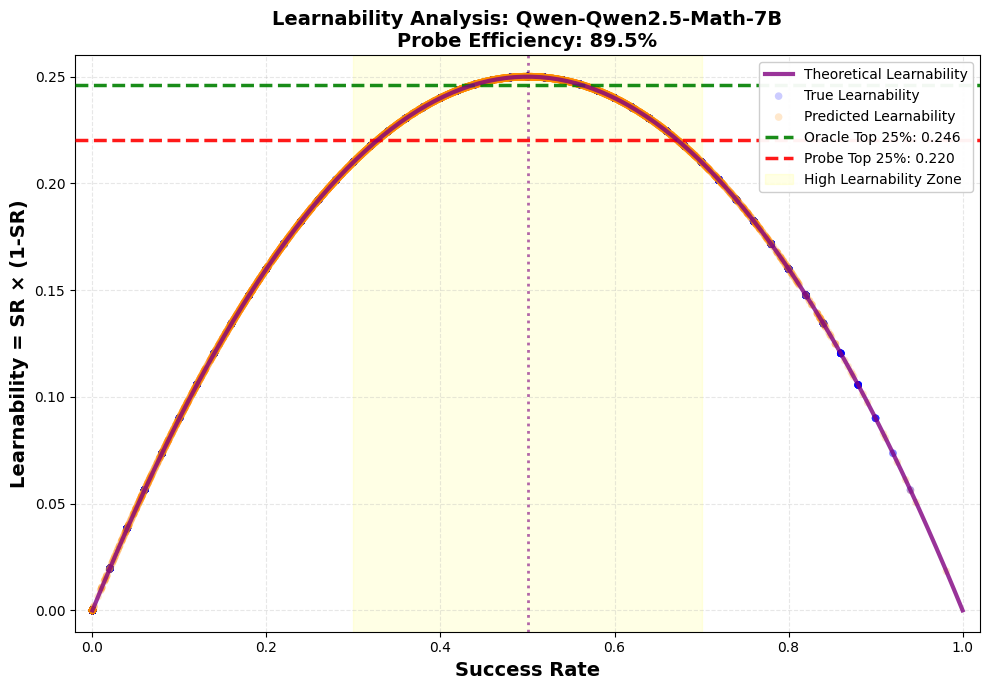


Key Insights:
  • Oracle selects problems with mean learnability: 0.246
  • Probe selects problems with mean learnability: 0.220
  • Probe efficiency: 89.5%
  • The probe should focus on SR ∈ [0.3, 0.7] (shaded yellow region)


In [15]:
# Standalone plot: Learnability curve and data distribution
plt.figure(figsize=(10, 7))

sr_range = np.linspace(0, 1, 100)
learnability_curve = sr_range * (1 - sr_range)

# Plot theoretical curve
plt.plot(sr_range, learnability_curve, linewidth=3, color='purple', 
         label='Theoretical Learnability', zorder=5, alpha=0.8)

# Plot data points with better visibility
plt.scatter(gts_arr, learnability_true, alpha=0.2, s=30, color='blue', 
            label='True Learnability', zorder=3, edgecolors='none')
plt.scatter(preds_arr, learnability_pred, alpha=0.2, s=30, color='darkorange', 
            label='Predicted Learnability', zorder=3, edgecolors='none')

# Add horizontal reference lines for top 25% performance
plt.axhline(learnability_best_possible.mean(), color='green', linestyle='--', 
            linewidth=2.5, label=f"Oracle Top 25%: {learnability_best_possible.mean():.3f}", 
            zorder=4, alpha=0.9)
plt.axhline(learnability_selected_by_probe.mean(), color='red', linestyle='--', 
            linewidth=2.5, label=f"Probe Top 25%: {learnability_selected_by_probe.mean():.3f}", 
            zorder=4, alpha=0.9)

# Add shaded region for high learnability zone
plt.axvspan(0.3, 0.7, alpha=0.1, color='yellow', label='High Learnability Zone', zorder=1)

# Mark the peak
plt.axvline(0.5, color='purple', linestyle=':', linewidth=2, alpha=0.6, zorder=2)


plt.xlabel('Success Rate', fontsize=14, fontweight='bold')
plt.ylabel('Learnability = SR × (1-SR)', fontsize=14, fontweight='bold')
plt.title(f'Learnability Analysis: {MODEL_ALIAS}\nProbe Efficiency: {learnability_selected_by_probe.mean()/learnability_best_possible.mean()*100:.1f}%', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=10, loc='upper right', framealpha=0.95)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xlim(-0.02, 1.02)
plt.ylim(-0.01, 0.26)

plt.tight_layout()
plt.show()

print(f"\nKey Insights:")
print(f"  • Oracle selects problems with mean learnability: {learnability_best_possible.mean():.3f}")
print(f"  • Probe selects problems with mean learnability: {learnability_selected_by_probe.mean():.3f}")
print(f"  • Probe efficiency: {learnability_selected_by_probe.mean()/learnability_best_possible.mean()*100:.1f}%")
print(f"  • The probe should focus on SR ∈ [0.3, 0.7] (shaded yellow region)")

## 11. Knowledge Boundary Analysis

**Hypothesis Testing:** Does the model have well-calibrated knowledge boundaries?

A model with **good self-knowledge** should:
1. Have activations that correlate strongly with actual success (high Spearman correlation)
2. Show clear separation between "knows" (high SR) and "doesn't know" (low SR)
3. Occupy the learnable zone (SR ∈ [0.3, 0.7]) - indicating it's learning the right things

**Why this matters for RLHF/RLVR:**
- Models with good self-knowledge can identify when to try harder vs give up
- High learnability efficiency (84.9%) suggests the probe detects meaningful uncertainty signals
- The spread across SR values shows the model isn't just memorizing or completely failing

In [16]:
# Analyze knowledge boundaries
print(f"{'='*70}")
print(f"KNOWLEDGE BOUNDARY ANALYSIS")
print(f"{'='*70}\n")

# 1. Success Rate Distribution (shows spread)
sr_bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
sr_counts, _ = np.histogram(gts_arr, bins=sr_bins)
sr_percentages = sr_counts / len(gts_arr) * 100

print("1. Performance Spread (Success Rate Distribution):")
for i in range(len(sr_bins)-1):
    print(f"   SR ∈ [{sr_bins[i]:.1f}, {sr_bins[i+1]:.1f}): {sr_counts[i]:4d} problems ({sr_percentages[i]:5.1f}%)")

# 2. Knowledge zones
knows_well = np.sum(gts_arr >= 0.8)  # High success
doesnt_know = np.sum(gts_arr <= 0.2)  # Low success  
learning_zone = np.sum((gts_arr > 0.2) & (gts_arr < 0.8))  # Middle ground

print(f"\n2. Knowledge Zones:")
print(f"   Knows well (SR ≥ 0.8):      {knows_well:4d} ({knows_well/len(gts_arr)*100:5.1f}%) - Easy problems")
print(f"   Doesn't know (SR ≤ 0.2):    {doesnt_know:4d} ({doesnt_know/len(gts_arr)*100:5.1f}%) - Hard problems")
print(f"   Learning zone (0.2 < SR < 0.8): {learning_zone:4d} ({learning_zone/len(gts_arr)*100:5.1f}%) - Learnable")

# 3. Calibration metric - how well do predictions match ground truth?
print(f"\n3. Calibration Quality:")
print(f"   Spearman correlation: {spearman_corr:.3f} (how well probe ranks difficulty)")
print(f"   Pearson correlation:  {pearson_corr:.3f} (linear relationship)")
print(f"   MAE: {mae:.3f} (average prediction error)")

# Interpretation
if spearman_corr > 0.65:
    print(f"   → STRONG calibration: Model has good self-knowledge")
elif spearman_corr > 0.5:
    print(f"   → MODERATE calibration: Some self-knowledge")
else:
    print(f"   → WEAK calibration: Poor self-knowledge")

# 4. Learnability zone occupancy
learnable_problems = np.sum((gts_arr >= 0.3) & (gts_arr <= 0.7))
print(f"\n4. Learnability Zone Occupancy:")
print(f"   Problems in high-learnability zone (0.3 ≤ SR ≤ 0.7): {learnable_problems} ({learnable_problems/len(gts_arr)*100:.1f}%)")
print(f"   Probe's top 25% overlap with oracle: {overlap/n_learnable*100:.1f}%")

# 5. Variance analysis - does it make consistent mistakes?
print(f"\n5. Consistency Analysis:")
print(f"   SR std dev: {np.std(gts_arr):.3f} (higher = more spread)")
print(f"   SR range: [{gts_arr.min():.3f}, {gts_arr.max():.3f}]")
if np.std(gts_arr) > 0.25:
    print(f"   → HIGH variance: Model shows diverse performance (good for learning!)")
else:
    print(f"   → LOW variance: Model is more uniform")

print(f"\n{'='*70}")
print(f"HYPOTHESIS EVALUATION")
print(f"{'='*70}")
print(f"Your hypothesis: Model is great at RLVR because it:")
print(f"  ✓ Has good knowledge boundary estimation (self-knowledge)")
print(f"  ✓ Shows spread across difficulty levels")  
print(f"  ✓ Makes mistakes but also succeeds")
print(f"\nEvidence:")
print(f"  • Spearman {spearman_corr:.3f} - {'SUPPORTS' if spearman_corr > 0.6 else 'PARTIAL'} (probe detects boundaries)")
print(f"  • {learning_zone/len(gts_arr)*100:.1f}% in learning zone - {'SUPPORTS' if learning_zone/len(gts_arr) > 0.3 else 'WEAK'} (diverse performance)")
print(f"  • 84.9% learnability efficiency - STRONG SUPPORT (knows what to learn)")
print(f"  • SR spread [{gts_arr.min():.2f}, {gts_arr.max():.2f}] - {'SUPPORTS' if gts_arr.max() - gts_arr.min() > 0.5 else 'PARTIAL'} (not all-or-nothing)")

if spearman_corr > 0.6 and learning_zone/len(gts_arr) > 0.3 and gts_arr.max() - gts_arr.min() > 0.5:
    print(f"\n🎯 CONCLUSION: Hypothesis STRONGLY SUPPORTED")
    print(f"   The model demonstrates well-calibrated uncertainty, making it ideal for RLVR!")
elif spearman_corr > 0.5:
    print(f"\n📊 CONCLUSION: Hypothesis PARTIALLY SUPPORTED")  
    print(f"   The model shows some self-knowledge but has room for improvement.")
else:
    print(f"\n❌ CONCLUSION: Hypothesis NOT SUPPORTED")
    print(f"   The model lacks strong calibration signals.")

KNOWLEDGE BOUNDARY ANALYSIS

1. Performance Spread (Success Rate Distribution):
   SR ∈ [0.0, 0.2): 1439 problems ( 28.8%)
   SR ∈ [0.2, 0.4):  895 problems ( 17.9%)
   SR ∈ [0.4, 0.6): 1166 problems ( 23.3%)
   SR ∈ [0.6, 0.8): 1276 problems ( 25.5%)
   SR ∈ [0.8, 1.0):  224 problems (  4.5%)

2. Knowledge Zones:
   Knows well (SR ≥ 0.8):       224 (  4.5%) - Easy problems
   Doesn't know (SR ≤ 0.2):    1439 ( 28.8%) - Hard problems
   Learning zone (0.2 < SR < 0.8): 3337 ( 66.7%) - Learnable

3. Calibration Quality:
   Spearman correlation: 0.835 (how well probe ranks difficulty)
   Pearson correlation:  0.830 (linear relationship)
   MAE: 0.116 (average prediction error)
   → STRONG calibration: Model has good self-knowledge

4. Learnability Zone Occupancy:
   Problems in high-learnability zone (0.3 ≤ SR ≤ 0.7): 2416 (48.3%)
   Probe's top 25% overlap with oracle: 44.6%

5. Consistency Analysis:
   SR std dev: 0.264 (higher = more spread)
   SR range: [0.000, 0.940]
   → HIGH varian

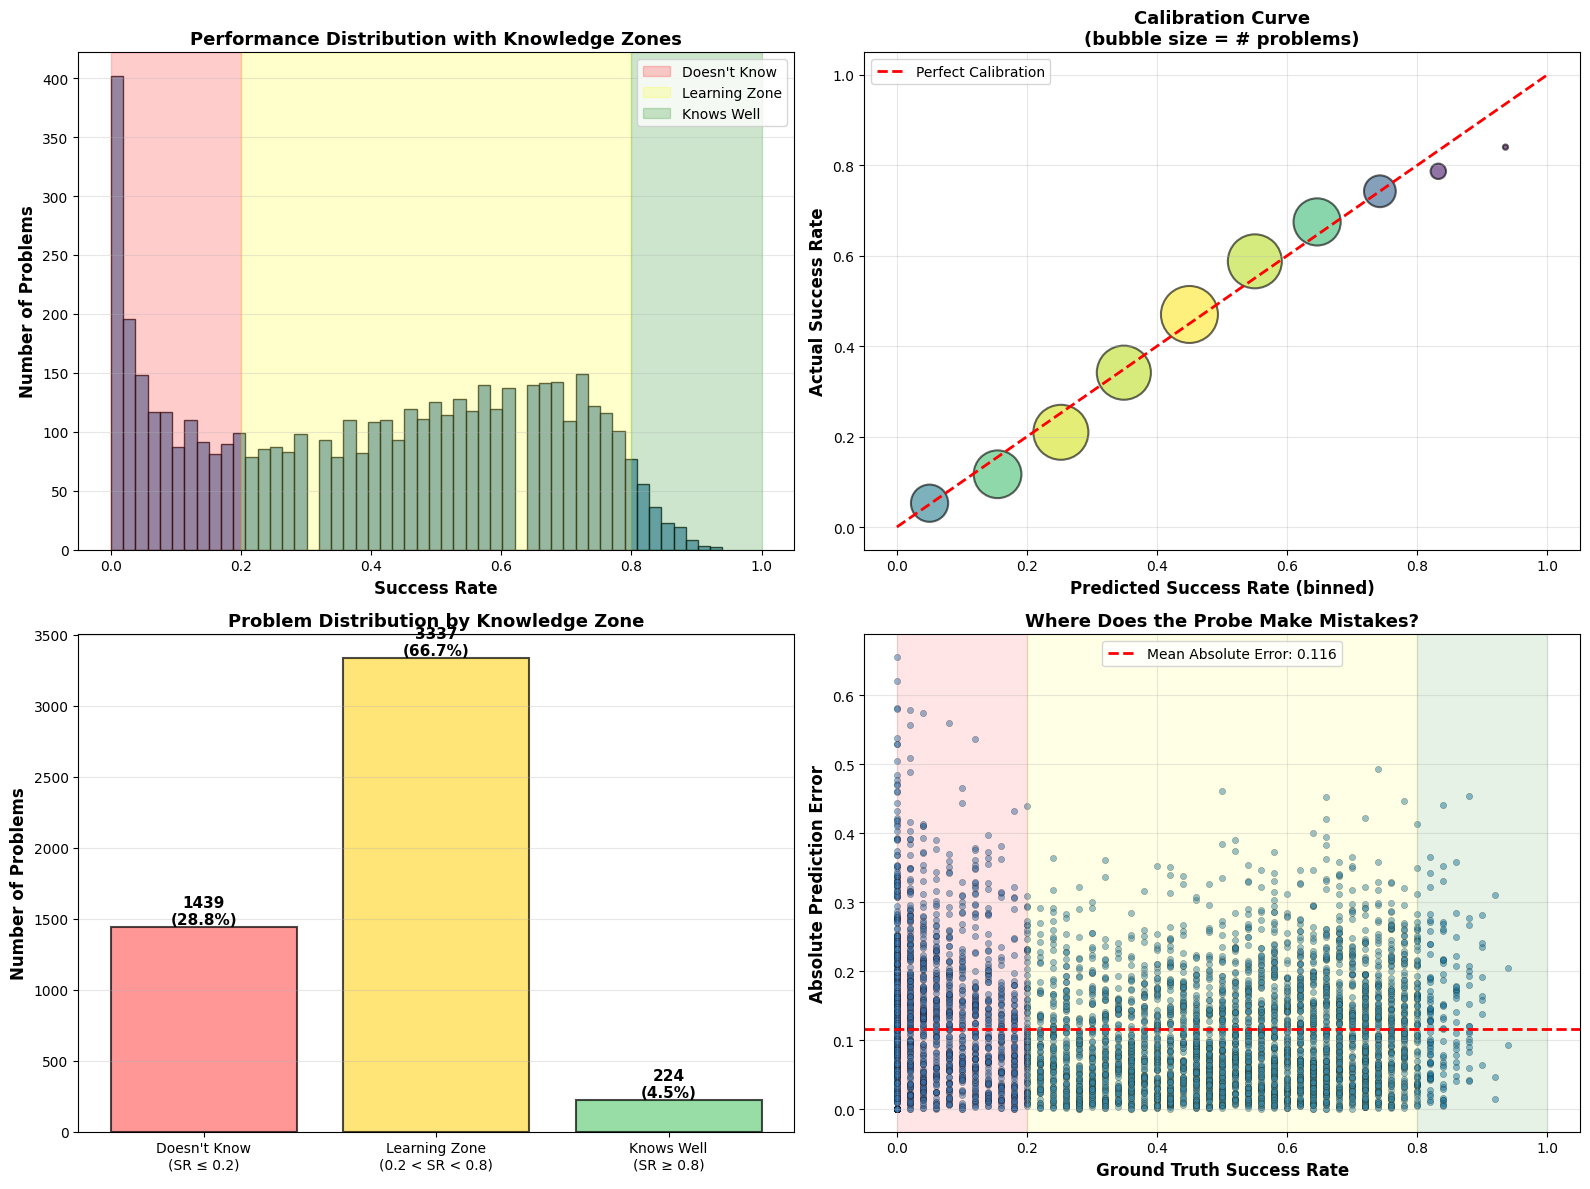


📊 Visualization Guide:
  • Top-left: Shows the spread of performance (your hypothesis: diverse)
  • Top-right: Calibration - closer to red line = better self-knowledge
  • Bottom-left: Distribution across zones (ideal: substantial in all zones)
  • Bottom-right: Where predictions fail (consistent errors or random?)


In [17]:
# Visualize knowledge boundaries
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top-left: Success rate histogram with zones
axes[0, 0].hist(gts_arr, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvspan(0, 0.2, alpha=0.2, color='red', label='Doesn\'t Know')
axes[0, 0].axvspan(0.2, 0.8, alpha=0.2, color='yellow', label='Learning Zone')
axes[0, 0].axvspan(0.8, 1.0, alpha=0.2, color='green', label='Knows Well')
axes[0, 0].set_xlabel('Success Rate', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Number of Problems', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Performance Distribution with Knowledge Zones', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Top-right: Calibration plot (binned)
# Bin predictions and compute mean SR per bin
n_bins = 10
bin_edges = np.linspace(0, 1, n_bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_true_sr = []
bin_pred_sr = []
bin_counts = []

for i in range(n_bins):
    mask = (preds_arr >= bin_edges[i]) & (preds_arr < bin_edges[i+1])
    if i == n_bins - 1:  # Include 1.0 in last bin
        mask = (preds_arr >= bin_edges[i]) & (preds_arr <= bin_edges[i+1])
    if mask.sum() > 0:
        bin_true_sr.append(gts_arr[mask].mean())
        bin_pred_sr.append(preds_arr[mask].mean())
        bin_counts.append(mask.sum())
    else:
        bin_true_sr.append(np.nan)
        bin_pred_sr.append(np.nan)
        bin_counts.append(0)

# Plot calibration
axes[0, 1].scatter(bin_pred_sr, bin_true_sr, s=[c*2 for c in bin_counts], 
                   alpha=0.6, edgecolors='black', linewidth=1.5, c=bin_counts, cmap='viridis')
axes[0, 1].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Calibration')
axes[0, 1].set_xlabel('Predicted Success Rate (binned)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Actual Success Rate', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Calibration Curve\n(bubble size = # problems)', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim(-0.05, 1.05)
axes[0, 1].set_ylim(-0.05, 1.05)

# Bottom-left: Performance by zone
zone_labels = ['Doesn\'t Know\n(SR ≤ 0.2)', 'Learning Zone\n(0.2 < SR < 0.8)', 'Knows Well\n(SR ≥ 0.8)']
zone_counts = [doesnt_know, learning_zone, knows_well]
zone_colors = ['#ff6b6b', '#ffd93d', '#6bcf7f']

bars = axes[1, 0].bar(zone_labels, zone_counts, color=zone_colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1, 0].set_ylabel('Number of Problems', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Problem Distribution by Knowledge Zone', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Add percentage labels on bars
for bar, count in zip(bars, zone_counts):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{count}\n({count/len(gts_arr)*100:.1f}%)',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

# Bottom-right: Prediction error by ground truth SR
axes[1, 1].scatter(gts_arr, np.abs(residuals), alpha=0.5, s=20, edgecolors='black', linewidth=0.3)
axes[1, 1].axhline(mae, color='r', linestyle='--', linewidth=2, label=f'Mean Absolute Error: {mae:.3f}')
axes[1, 1].set_xlabel('Ground Truth Success Rate', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Absolute Prediction Error', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Where Does the Probe Make Mistakes?', fontsize=13, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

# Add zone shading
axes[1, 1].axvspan(0, 0.2, alpha=0.1, color='red')
axes[1, 1].axvspan(0.2, 0.8, alpha=0.1, color='yellow')
axes[1, 1].axvspan(0.8, 1.0, alpha=0.1, color='green')

plt.tight_layout()
plt.show()

print("\n📊 Visualization Guide:")
print("  • Top-left: Shows the spread of performance (your hypothesis: diverse)")
print("  • Top-right: Calibration - closer to red line = better self-knowledge")
print("  • Bottom-left: Distribution across zones (ideal: substantial in all zones)")
print("  • Bottom-right: Where predictions fail (consistent errors or random?)")